In [1]:
!wget https://download.microsoft.com/download/a/d/f/adfce572-617f-4fd0-a822-af6f05cbe61f/MicrosoftGestureDataset.zip
!unzip MicrosoftGestureDataset.zip -d MSRC_12

--2025-04-25 23:11:56--  https://download.microsoft.com/download/a/d/f/adfce572-617f-4fd0-a822-af6f05cbe61f/MicrosoftGestureDataset.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.196.38.9, 2600:1406:cc00:289::317f, 2600:1406:cc00:284::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.196.38.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173190554 (165M) [application/octet-stream]
Saving to: ‘MicrosoftGestureDataset.zip’

MicrosoftGestureDat 100%[===================>] 165.17M  10.8MB/s    in 17s     

2025-04-25 23:12:14 (9.55 MB/s) - ‘MicrosoftGestureDataset.zip’ saved [173190554/173190554]

Archive:  MicrosoftGestureDataset.zip
   creating: MSRC_12/MicrosoftGestureDataset-RC/code/
  inflating: MSRC_12/MicrosoftGestureDataset-RC/code/demo1.m  
  inflating: MSRC_12/MicrosoftGestureDataset-RC/code/load_file.m  
  inflating: MSRC_12/MicrosoftGestureDataset-RC/code/load_tagstream.m  
  inflating: MSRC_12/MicrosoftGesture

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install torch-geometric

Looking in indexes: https://download.pytorch.org/whl/cpu
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 MB 6.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.1 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data

data_dir = "/content/MSRC_12/MicrosoftGestureDataset-RC/data"
csv_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".csv")])

skeleton_edges = [
    (0, 1), (1, 2), (2, 3),
    (2, 4), (4, 5), (5, 6), (6, 7),
    (2, 8), (8, 9), (9, 10), (10, 11),
    (0, 12), (12, 13), (13, 14), (14, 15),
    (0, 16), (16, 17), (17, 18), (18, 19)
]
skeleton_edges += [(j, i) for (i, j) in skeleton_edges]

def convert_tick_to_usec(xqpctick):
    return (xqpctick * 1000 + 49875 / 2) / 49875

data_list = []
gesture_to_index = {}
window_before = 30

for csv_file in csv_files:
    tag_file = csv_file.replace(".csv", ".tagstream")
    csv_path = os.path.join(data_dir, csv_file)
    tag_path = os.path.join(data_dir, tag_file)
    if not os.path.exists(tag_path):
        continue

    df = pd.read_csv(csv_path, header=None, sep=r"\s+")
    timestamps = df.iloc[:, 0].astype(np.float64).values
    X = df.iloc[:, 1:].values.reshape(-1, 20, 4)[:, :, :3]
    T = len(X)

    tags = []
    with open(tag_path, "r") as f:
        for line in f.readlines()[1:]:
            parts = line.strip().split(";")
            if len(parts) != 2:
                continue
            tags.append({"tick": int(parts[0]), "tagname": parts[1].strip().split()[0]})

    for tag in tags:
        timestamp_usec = convert_tick_to_usec(tag["tick"])
        frame_id = np.argmin(np.abs(timestamps - timestamp_usec))
        start = max(0, frame_id - window_before)
        end = frame_id + 1
        segment = X[start:end]
        F = segment.shape[0]

        xyz = segment.reshape(F * 20, 3)
        t_feat = np.repeat(np.linspace(0, 1, F), 20)[:, None]
        joint_feat = np.tile(np.arange(20), F)[:, None] / 19.0
        features = np.concatenate([xyz, t_feat, joint_feat], axis=1)
        node_features = torch.tensor(features, dtype=torch.float32)

        edge_index = []
        for t in range(F):
            for (i, j) in skeleton_edges:
                edge_index.append((t * 20 + i, t * 20 + j))
        for t in range(F - 1):
            for j in range(20):
                edge_index.append((t * 20 + j, (t + 1) * 20 + j))
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        label = tag["tagname"]
        if label not in gesture_to_index:
            gesture_to_index[label] = len(gesture_to_index)
        y = torch.tensor([gesture_to_index[label]])

        data = Data(x=node_features, edge_index=edge_index, y=y)
        data_list.append(data)

NUM_CLASSES = len(gesture_to_index)
INPUT_DIM = 5


In [4]:
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

def get_msrc12_dataloaders(data_list, batch_size=32, val_ratio=0.15, test_ratio=0.15, shuffle=True):
    labels = [int(data.y.item()) for data in data_list]
    temp_ratio = val_ratio + test_ratio

    # Divided into train and temporary set (val+test)
    train_data, temp_data, train_labels, temp_labels = train_test_split(
        data_list, labels, test_size=temp_ratio, stratify=labels, random_state=42
    )

    # Then divide val and test from the temporary set
    val_size = val_ratio / temp_ratio
    val_data, test_data, _, _ = train_test_split(
        temp_data, temp_labels, test_size=1 - val_size, stratify=temp_labels, random_state=42
    )

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader
train_loader, val_loader, test_loader = get_msrc12_dataloaders(data_list, batch_size=32)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, out_channels):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
        self.classifier = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for conv in self.layers:
            x = F.relu(conv(x, edge_index))
        x = global_mean_pool(x, batch)       # Global graph-level representation: [batch_size, hidden_dim]
        return self.classifier(x)            # Output logits for classification


In [6]:
import torch.optim as optim

def accuracy(y_true, y_pred):
    pred_labels = y_pred.argmax(dim=1)
    correct = (pred_labels == y_true).sum().item()
    total = y_true.size(0)
    return correct / total

def evaluate(model, data_loader, device):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            out = model(data)                          # logits
            loss = F.cross_entropy(out, data.y)
            total_loss += loss.item() * data.y.size(0)
            total_correct += (out.argmax(dim=1) == data.y).sum().item()
            total_samples += data.y.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_acc, avg_loss

def train(model, train_loader, val_loader, lr=0.01, epochs=20, device='cpu'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_acc = 0
    best_model_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.cross_entropy(out, data.y)
            loss.backward()
            optimizer.step()

        acc_train, loss_train = evaluate(model, train_loader, device)
        acc_val, loss_val = evaluate(model, val_loader, device)
        print(f"Epoch {epoch:2d} | Train Loss: {loss_train:.4f} Acc: {acc_train*100:.2f}% | Val Acc: {acc_val*100:.2f}%")

        if acc_val > best_val_acc:
            best_val_acc = acc_val
            best_model_state = model.state_dict()

    if best_model_state:
        model.load_state_dict(best_model_state)
    return model


In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = GNNModel(
    in_channels=INPUT_DIM,          # = 5: [x, y, z, t, joint_id]
    hidden_channels=300,
    num_layers=5,                   # GCN layers
    out_channels=NUM_CLASSES
)


model = train(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=0.01,
    epochs=20,
    device=device
)


test_acc, test_loss = evaluate(model, test_loader, device)
print(f"\n✅ Final Test Accuracy: {test_acc * 100:.2f}% | Test Loss: {test_loss:.4f}")


Epoch  1 | Train Loss: 1.9742 Acc: 27.42% | Val Acc: 27.96%
Epoch  2 | Train Loss: 1.4939 Acc: 50.69% | Val Acc: 49.31%
Epoch  3 | Train Loss: 1.1170 Acc: 65.35% | Val Acc: 67.56%
Epoch  4 | Train Loss: 0.8823 Acc: 74.52% | Val Acc: 74.71%
Epoch  5 | Train Loss: 0.6920 Acc: 81.18% | Val Acc: 79.94%
Epoch  6 | Train Loss: 0.6145 Acc: 82.16% | Val Acc: 82.07%
Epoch  7 | Train Loss: 0.5091 Acc: 84.93% | Val Acc: 84.53%
Epoch  8 | Train Loss: 0.4754 Acc: 86.05% | Val Acc: 85.81%
Epoch  9 | Train Loss: 0.4465 Acc: 87.40% | Val Acc: 86.98%
Epoch 10 | Train Loss: 0.3590 Acc: 89.71% | Val Acc: 88.90%
Epoch 11 | Train Loss: 0.3707 Acc: 88.75% | Val Acc: 88.58%
Epoch 12 | Train Loss: 0.3545 Acc: 88.72% | Val Acc: 88.90%
Epoch 13 | Train Loss: 0.3135 Acc: 92.04% | Val Acc: 89.86%
Epoch 14 | Train Loss: 0.3266 Acc: 90.83% | Val Acc: 88.79%
Epoch 15 | Train Loss: 0.2587 Acc: 92.13% | Val Acc: 90.93%
Epoch 16 | Train Loss: 0.2572 Acc: 92.54% | Val Acc: 90.61%
Epoch 17 | Train Loss: 0.2906 Acc: 90.83

<Figure size 800x600 with 0 Axes>

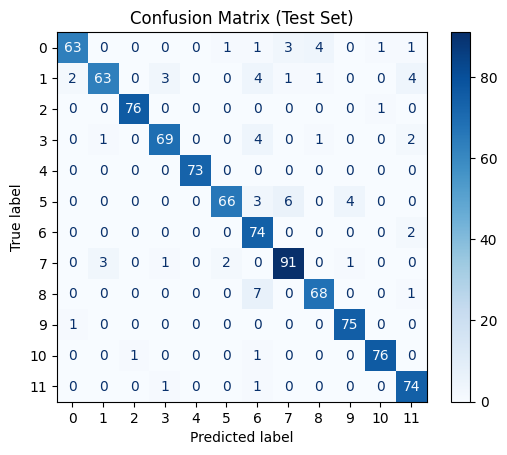

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.show()
